In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/DL Project')
os.getcwd()
os.listdir()

['ErensCopy.ipynb',
 'uci-news-aggregator.csv',
 "Juhi'sCopy.ipynb",
 'glove.6B.zip',
 "Elif'sCopy.ipynb",
 'news-category-dataset.zip',
 'News_Category_Dataset_v2.json',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'Results.gdoc',
 'glove.6B.100d.txt.word2vec',
 'Copy of NewData ErensCopy.ipynb',
 'Notes for DL Project.gdoc',
 'Validation Accuracy 5-Fold CV.png',
 'Validation Loss 5-Fold CV.png',
 'Validation Loss 5-Fold CV New Data.png',
 'Validation Accuracy 5-Fold CV New Data.png',
 'NewData ErensCopy.ipynb',
 'DL Project Report.gdoc']

**Import Dataset**

In [0]:
df = pd.read_csv('uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])

In [0]:
df.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

**Preprocessing**

In [0]:
#Preprocessing taken from Kaggle https://www.kaggle.com/ngyptr/multi-class-classification-with-lstm
#Balancing classes
num_of_categories = 45639 #number of m classes
shuffled = df.reindex(np.random.permutation(df.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [0]:
concated.head()

,TITLE,CATEGORY,LABEL
58271,Citi looks perfectly priced – for more mediocrity,b,0
16344,"Buddy-action enough for '22 Jump Street,' but ...",e,0
74854,Japan overhauls its public pension fund,b,0
136469,Computer Used to Create Internet on Display fo...,t,0
94639,"Facebook updates Paper to v1.1, No Android app...",t,0


In [0]:
#One-hot encode the lab
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3

if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)

concated.head()


,TITLE,CATEGORY,LABEL
58271,Citi looks perfectly priced – for more mediocrity,b,1
16344,"Buddy-action enough for '22 Jump Street,' but ...",e,0
74854,Japan overhauls its public pension fund,b,1
136469,Computer Used to Create Internet on Display fo...,t,2
94639,"Facebook updates Paper to v1.1, No Android app...",t,2


In [0]:
concated=df

In [0]:
to_drop = []
titles = concated['TITLE'].values
for i in range(len(titles)):
  if "http" in titles[i]:
    to_drop.append(i)

In [0]:
data = concated.reset_index()
data = data.drop('index', axis=1)
data = data.drop(to_drop)

In [0]:
#labels = to_categorical(data['LABEL'], num_classes=4)
#do this instead of above
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(data['CATEGORY']), num_classes=4)

In [0]:
#we can remove the uncommon words
vocab_size= 50000
t = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~–')
t.fit_on_texts(data['TITLE'].values)

In [10]:
len(t.word_index)

73323

In [0]:
sequences = t.texts_to_sequences(data['TITLE'].values)

In [12]:
current_max = 0
max_index = 0
for i in range(len(sequences)):
  m = len(sequences[i])
  if m > current_max:
    current_max=m
    max_index = i
print(current_max)
print(max_index)
    

19
1312


In [0]:
X = pad_sequences(sequences)

In [14]:
len(X), len(labels)

(422398, 422398)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

In [0]:
X_train.shape

(316798, 19)

**Models**

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [0]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Y_reg = data['CATEGORY']

**LSTM w/ cross validation**

In [0]:
#cross validation -- beware lasts long
cvscores = []
loss_vals = []
val_accs = []
for train, test in kfold.split(X, Y_reg):
  #Turn labels into categorical after the split
  encoder = LabelEncoder()
  Y = to_categorical(encoder.fit_transform(Y_reg), num_classes=4)
  #define the model
  model = Sequential()
  model.add(Embedding(vocab_size, output_dim=100, input_length=X.shape[1]))
  model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  #fit the model
  history = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=128)
  #predict
  score = model.evaluate(X[test], Y[test], verbose=0)
  #store values
  loss_vals.append(history.history['val_loss'])
  val_accs.append(history.history['val_acc'])
  cvscores.append(scores[1])
model.summary()

In [0]:
#define the model
model = Sequential()
model.add(Embedding(vocab_size, output_dim=100, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#fit
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
#predict


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 19, 100)           5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
Train on 316798 samples, validate on 105600 samples
Epoch 1/5
316798/316798 [==============================] - 225s 710us/step - loss: 0.2628 - acc: 0.9063 - val_loss: 0.1586 - val_acc: 0.9455
Epoch 2/5
316798/316798 [==============================] - 226s 712us/step - loss: 0.1380 - acc: 0.9522 - val_loss: 0.1534 - val_acc: 0.9484
Epoch 3/5
316798/316798 [==============================] - 218

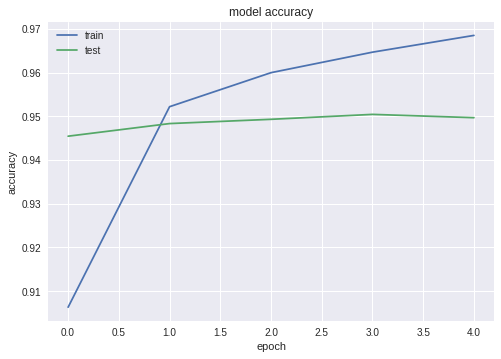

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

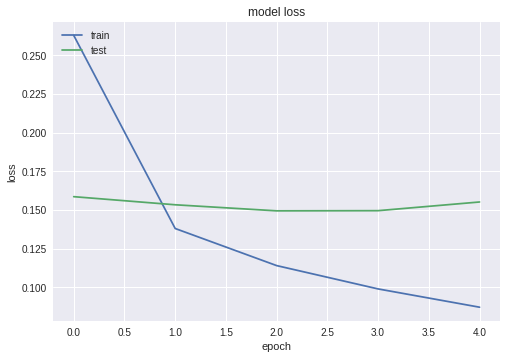

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
print(history.history['val_loss'])
print(history.history['val_acc'])

[0.15859352911512056, 0.15335268914699554, 0.14943012169364728, 0.14954469836571, 0.15515696221228803]
[0.9454640151515151, 0.9483522727272727, 0.9493276515151515, 0.9504545454545454, 0.9496969696969697]


**Single Convolution Model**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 19, 128)           6400000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 128)           49280     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
__________

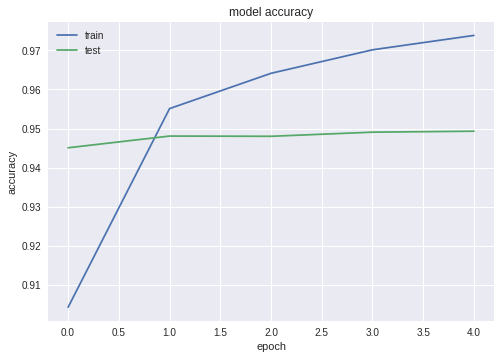

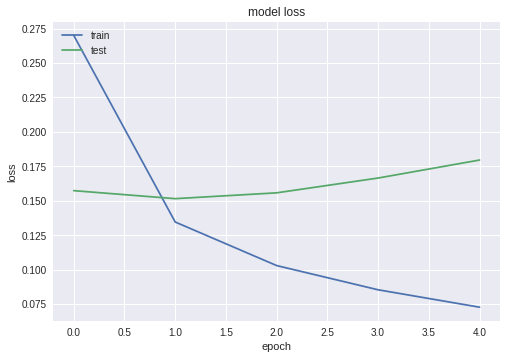

In [0]:
#Single Convolution Model

model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=X.shape[1]))
model.add(Conv1D(128,3,padding='valid',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

#fit the model
history_Single_CNN = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=128)
#predict
score_Single_CNN = model.evaluate(X[test], Y[test], verbose=0)

# summarize history for accuracy
plt.plot(history_Single_CNN.history['acc'])
plt.plot(history_Single_CNN.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_Single_CNN.history['loss'])
plt.plot(history_Single_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
print(history_Single_CNN.history['val_loss'])
print(history_Single_CNN.history['val_acc'])

[0.15731332917880936, 0.15148974031593054, 0.15572377686387678, 0.1664767163392361, 0.17954764702235193]
[0.9450882446940733, 0.9480830009114476, 0.9480238160059659, 0.9490773073235402, 0.9493258839265634]


**3-Layer Convolution Model**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 19, 128)           6400000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 9, 300)            115500    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 4, 150)            135150    
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 150)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 75)             33825     
_________________________________________________________________
flatten_2 (Flatten)          (None, 75)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 75)                0         
__________

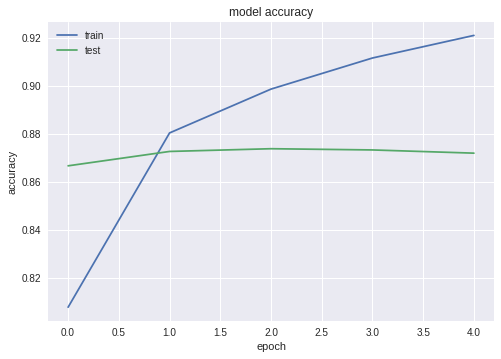

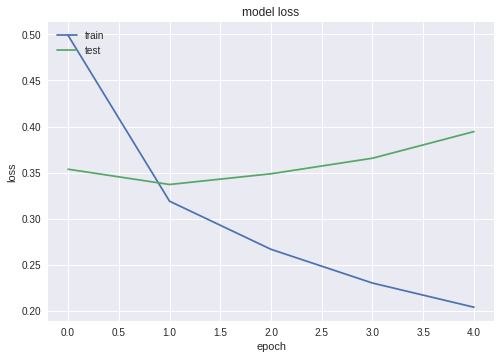

[0.35368714871428963, 0.3371267047234158, 0.3487432233647846, 0.3656289123737855, 0.39452533953284197]
[0.8667155928551982, 0.8727051052899468, 0.8738414554751956, 0.873332465288053, 0.8719948864241663]


In [0]:
#Triple Convolution Model

#define the model
model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=X.shape[1]))

model.add(Conv1D(300, 3, padding='valid',activation='relu',strides=2))
model.add(Conv1D(150, 3, padding='valid',activation='relu',strides=2))
model.add(Dropout(0.4))
model.add(Conv1D(75, 3, padding='valid',activation='relu',strides=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(150,activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(4,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

model.summary()

#fit the model
history_Triple_CNN = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=128)
#predict
score_Triple_CNN = model.evaluate(X[test], Y[test], verbose=0)

# summarize history for accuracy
plt.plot(history_Triple_CNN.history['acc'])
plt.plot(history_Triple_CNN.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_Triple_CNN.history['loss'])
plt.plot(history_Triple_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(history_Triple_CNN.history['val_loss'])
print(history_Triple_CNN.history['val_acc'])

**Joint CNN + LSTM model**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 19, 100)           5000000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 15, 64)            32064     
_________________________________________________________________
dropout_11 (Dropout)         (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 404       
Total params: 5,098,468
Trainable params: 5,098,468
Non-trainable params: 0
_________________________________________________________________


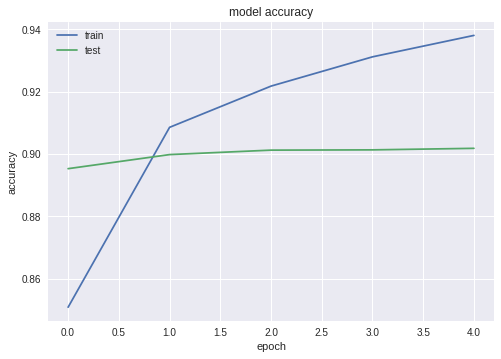

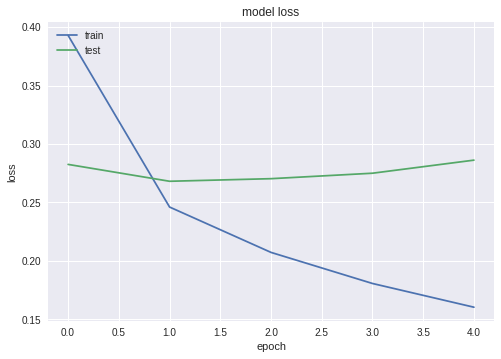

[0.28247254411379497, 0.2680410845622872, 0.2702579854744853, 0.27493210486390374, 0.28611810332897936]
[0.8953125, 0.8998295454545454, 0.9012594696969697, 0.901344696969697, 0.9018371212121212]


In [0]:
#CNN + LSTM model
model_conv = Sequential()
model_conv.add(Embedding(vocab_size, 100, input_length=X.shape[1]))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(Dropout(0.4))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model_conv.add(Dense(4, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

history_CNN_LSTM = model_conv.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
score_CNN_LSTM = model_conv.evaluate(X_test, y_test)

# summarize history for accuracy
plt.plot(history_CNN_LSTM.history['acc'])
plt.plot(history_CNN_LSTM.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_CNN_LSTM.history['loss'])
plt.plot(history_CNN_LSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(history_CNN_LSTM.history['val_loss'])
print(history_CNN_LSTM.history['val_acc'])

**Word2Vec Embedding**

In [17]:
!pip install gensim

    100% |████████████████████████████████| 23.6MB 1.7MB/s 
    100% |████████████████████████████████| 1.4MB 16.2MB/s 
    100% |████████████████████████████████| 133kB 26.1MB/s 
    100% |████████████████████████████████| 5.1MB 7.3MB/s 
    100% |████████████████████████████████| 61kB 23.4MB/s 
    100% |████████████████████████████████| 552kB 25.1MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [0]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 100)

In [0]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
word2vec = KeyedVectors.load_word2vec_format(filename, binary=False)

In [19]:
from keras.layers import Embedding
word_index = t.word_index
nb_words = min(vocab_size, len(word_index))+1

EMBEDDING_DIM=100

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        try: embedding_matrix[i] = word2vec.word_vec(word)
        except: break
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 16089


In [21]:
#CNN after word2vec
model = Sequential()

model.add(Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
model.add(Conv1D(128,3,padding='valid',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

history_CNN_word2vec = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
pred_y_CNN = model.predict(X_test)
'''
# summarize history for accuracy
plt.plot(history_CNN_word2vec.history['acc'])
plt.plot(history_CNN_word2vec.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_CNN_word2vec.history['loss'])
plt.plot(history_CNN_word2vec.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(history_CNN_word2vec.history['val_loss'])
print(history_CNN_word2vec.history['val_acc'])
'''
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.argmax(axis=1), pred_y_CNN.argmax(axis=1))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 19, 100)           5000100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 128)           38528     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
__________

array([[27044,   389,   364,  1283],
       [  394, 37196,   182,   311],
       [  274,   200, 10707,   143],
       [ 1289,   326,   140, 25358]])

**LSTM Model w/ word2vec embedding**

In [22]:
#LSTM after word2vec
model = Sequential()
model.add(Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history_LSTM_word2vec = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
pred_LSTM_word2vec = model.predict(X_test)
'''
# summarize history for accuracy
plt.plot(history_LSTM_word2vec.history['acc'])
plt.plot(history_LSTM_word2vec.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_LSTM_word2vec.history['loss'])
plt.plot(history_LSTM_word2vec.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print(history_LSTM_word2vec.history['val_loss'])
print(history_LSTM_word2vec.history['val_acc'])
'''
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.argmax(axis=1), pred_LSTM_word2vec.argmax(axis=1))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 19, 100)           5000100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 404       
Total params: 5,080,904
Trainable params: 5,080,904
Non-trainable params: 0
_________________________________________________________________
Train on 316798 samples, validate on 105600 samples
Epoch 1/5
316798/316798 [==============================] - 203s 641us/step - loss: 0.3176 - acc: 0.8859 - val_loss: 0.1752 - val_acc: 0.9385
Epoch 2/5
316798/316798 [==============================] - 202s 639us/step - loss: 0.1696 - acc: 0.9411 - val_loss: 0.1489 - val_acc: 0.9482
Epoch 3/5
316798/316798 [==============================] - 201

array([[27180,   390,   262,  1248],
       [  349, 37285,   138,   311],
       [  311,   196, 10686,   131],
       [ 1304,   287,   111, 25411]])

**Above Models with Cross Validation**

In [0]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Y_reg = data['CATEGORY']

In [0]:
cvscores = {}
loss_vals = {}
val_accs = {}

In [0]:
#cross validation -- beware lasts long
cvscores['LSTM'] = []
loss_vals['LSTM'] = []
val_accs['LSTM'] = []
for train, test in kfold.split(X, Y_reg):
  #Turn labels into categorical after the split
  encoder = LabelEncoder()
  Y = to_categorical(encoder.fit_transform(Y_reg), num_classes=4)
  #define the model
  model = Sequential()
  model.add(Embedding(vocab_size, output_dim=100, input_length=X.shape[1]))
  model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  #fit the model
  history = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=128)
  #predict
  score = model.evaluate(X[test], Y[test], verbose=0)
  #store values
  loss_vals['LSTM'].append(history.history['val_loss'])
  val_accs['LSTM'].append(history.history['val_acc'])
  cvscores['LSTM'].append(score[1])
  
  
model.summary()

In [0]:
#cross validation -- this is actually regular CNN
cvscores['CNN_word2vec'] = []
loss_vals['CNN_word2vec'] = []
val_accs['CNN_word2vec'] = []
for train, test in kfold.split(X, Y_reg):
  #Turn labels into categorical after the split
  encoder = LabelEncoder()
  Y = to_categorical(encoder.fit_transform(Y_reg), num_classes=4)
  #define the model
  model = Sequential()

  model.add(Embedding(vocab_size, 128, input_length=X.shape[1]))
  model.add(Conv1D(128,3,padding='valid',activation='relu',strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(128))
  model.add(Dropout(0.5))
  model.add(Activation('relu'))
  model.add(Dense(4))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

  #fit the model
  history = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=128)
  #predict
  score = model.evaluate(X[test], Y[test], verbose=0)
  #store values
  loss_vals['CNN_word2vec'].append(history.history['val_loss'])
  val_accs['CNN_word2vec'].append(history.history['val_acc'])
  cvscores['CNN_word2vec'].append(score[1])
  
  
model.summary()

print(loss_vals['CNN_word2vec'])
print(val_accs['CNN_word2vec'])
print(cvscores['CNN_word2vec'])

Train on 337917 samples, validate on 84481 samples
Epoch 1/5
337917/337917 [==============================] - 53s 158us/step - loss: 0.2713 - acc: 0.9042 - val_loss: 0.1587 - val_acc: 0.9453
Epoch 2/5
337917/337917 [==============================] - 44s 132us/step - loss: 0.1351 - acc: 0.9547 - val_loss: 0.1484 - val_acc: 0.9489
Epoch 3/5
337917/337917 [==============================] - 41s 122us/step - loss: 0.1037 - acc: 0.9643 - val_loss: 0.1534 - val_acc: 0.9485
Epoch 4/5
337917/337917 [==============================] - 41s 121us/step - loss: 0.0846 - acc: 0.9700 - val_loss: 0.1671 - val_acc: 0.9494
Epoch 5/5
337917/337917 [==============================] - 42s 124us/step - loss: 0.0719 - acc: 0.9742 - val_loss: 0.1820 - val_acc: 0.9480
Train on 337918 samples, validate on 84480 samples
Epoch 1/5
337918/337918 [==============================] - 42s 125us/step - loss: 0.2697 - acc: 0.9052 - val_loss: 0.1546 - val_acc: 0.9467
Epoch 2/5
337918/337918 [==============================] -

In [0]:
#cross validation -- beware lasts long
cvscores['CNN_word2vec_actual'] = []
loss_vals['CNN_word2vec_actual'] = []
val_accs['CNN_word2vec_actual'] = []
for train, test in kfold.split(X, Y_reg):
  #Turn labels into categorical after the split
  encoder = LabelEncoder()
  Y = to_categorical(encoder.fit_transform(Y_reg), num_classes=4)
  #define the model
  model = Sequential()

  model.add(Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
  model.add(Conv1D(128,3,padding='valid',activation='relu',strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(128))
  model.add(Dropout(0.5))
  model.add(Activation('relu'))
  model.add(Dense(4))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

  #fit the model
  history = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=128)
  #predict
  score = model.evaluate(X[test], Y[test], verbose=0)
  #store values
  loss_vals['CNN_word2vec_actual'].append(history.history['val_loss'])
  val_accs['CNN_word2vec_actual'].append(history.history['val_acc'])
  cvscores['CNN_word2vec_actual'].append(score[1])
  
  
model.summary()

print(loss_vals['CNN_word2vec_actual'])
print(val_accs['CNN_word2vec_actual'])
print(cvscores['CNN_word2vec_actual'])

Train on 337917 samples, validate on 84481 samples
Epoch 1/5
337917/337917 [==============================] - 42s 125us/step - loss: 0.3180 - acc: 0.8899 - val_loss: 0.1770 - val_acc: 0.9392
Epoch 2/5
337917/337917 [==============================] - 41s 121us/step - loss: 0.1685 - acc: 0.9434 - val_loss: 0.1526 - val_acc: 0.9471
Epoch 3/5
337917/337917 [==============================] - 40s 120us/step - loss: 0.1354 - acc: 0.9542 - val_loss: 0.1511 - val_acc: 0.9485
Epoch 4/5
337917/337917 [==============================] - 40s 118us/step - loss: 0.1158 - acc: 0.9602 - val_loss: 0.1521 - val_acc: 0.9501
Epoch 5/5
337917/337917 [==============================] - 40s 118us/step - loss: 0.1026 - acc: 0.9644 - val_loss: 0.1583 - val_acc: 0.9497
Train on 337918 samples, validate on 84480 samples
Epoch 1/5
337918/337918 [==============================] - 42s 123us/step - loss: 0.3171 - acc: 0.8898 - val_loss: 0.1758 - val_acc: 0.9404
Epoch 2/5
337918/337918 [==============================] -

In [0]:
#cross validation -- beware lasts long
cvscores['LSTM_word2vec'] = []
loss_vals['LSTM_word2vec'] = []
val_accs['LSTM_word2vec'] = []
for train, test in kfold.split(X, Y_reg):
  #Turn labels into categorical after the split
  encoder = LabelEncoder()
  Y = to_categorical(encoder.fit_transform(Y_reg), num_classes=4)
  #define the model
  model = Sequential()
  model.add(Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
  model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #fit the model
  history = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=128)
  #predict
  score = model.evaluate(X[test], Y[test], verbose=0)
  #store values
  loss_vals['LSTM_word2vec'].append(history.history['val_loss'])
  val_accs['LSTM_word2vec'].append(history.history['val_acc'])
  cvscores['LSTM_word2vec'].append(score[1])
  
  
model.summary()
print(loss_vals['LSTM_word2vec'])
print(val_accs['LSTM_word2vec'])
print(cvscores['LSTM_word2vec'])

Train on 337917 samples, validate on 84481 samples
Epoch 1/5
337917/337917 [==============================] - 238s 706us/step - loss: 0.3106 - acc: 0.8889 - val_loss: 0.1727 - val_acc: 0.9385
Epoch 2/5
337917/337917 [==============================] - 233s 690us/step - loss: 0.1664 - acc: 0.9420 - val_loss: 0.1485 - val_acc: 0.9473
Epoch 3/5
337917/337917 [==============================] - 232s 686us/step - loss: 0.1332 - acc: 0.9536 - val_loss: 0.1427 - val_acc: 0.9500
Epoch 4/5
337917/337917 [==============================] - 230s 681us/step - loss: 0.1153 - acc: 0.9590 - val_loss: 0.1402 - val_acc: 0.9519
Epoch 5/5
337917/337917 [==============================] - 230s 680us/step - loss: 0.1030 - acc: 0.9634 - val_loss: 0.1436 - val_acc: 0.9517
Train on 337918 samples, validate on 84480 samples
Epoch 1/5
337918/337918 [==============================] - 234s 692us/step - loss: 0.3120 - acc: 0.8878 - val_loss: 0.1751 - val_acc: 0.9390
Epoch 2/5
337918/337918 [===========================

**Logistic Regression Model**

In [0]:
#cross validation -- beware lasts long
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

cvscores['logreg'] = []

for train, test in kfold.split(x, y):
  # Instantiate the classifier: clf
  clf = OneVsRestClassifier(LogisticRegression())

  # Fit the classifier to the training data
  clf.fit(x[train], y[train])

  score = clf.score(x[test], y[test])
  #store values
  cvscores['logreg'].append(score)
  

In [0]:
print(cvscores['logreg'])

[0.9473017601590891, 0.9486979166666667, 0.948544034090909, 0.9493957078090413, 0.947761547385118]


**Logistic Regression**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = CountVectorizer()
x = vectorizer.fit_transform(data['TITLE'])

encoder = LabelEncoder()
y = encoder.fit_transform(data['CATEGORY'])


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,random_state=42 )


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(x_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(x_test, y_test)))

Accuracy: 0.9479924242424242


**Results**

In [0]:
history_CNN_word2vec_val_loss = [0.1587111066868811, 0.15133722459276516, 0.16115968309568637, 0.16717950223521752, 0.18063089211556044]
history_CNN_word2vec_val_acc = [0.9453314393939394, 0.9487121212121212, 0.948030303030303, 0.9492140151515152, 0.9490435606060607]

history_CNN_LSTM_val_loss = [0.28247254411379497, 0.2680410845622872, 0.2702579854744853, 0.27493210486390374, 0.28611810332897936]
history_CNN_LSTM_val_acc = [0.8953125, 0.8998295454545454, 0.9012594696969697, 0.901344696969697, 0.9018371212121212]

history_CNN_3layer_val_loss = [0.35368714871428963, 0.3371267047234158, 0.3487432233647846, 0.3656289123737855, 0.39452533953284197]
history_CNN_3layer_val_acc = [0.8667155928551982, 0.8727051052899468, 0.8738414554751956, 0.873332465288053, 0.8719948864241663]

history_Single_CNN_val_loss = [0.15731332917880936, 0.15148974031593054, 0.15572377686387678, 0.1664767163392361, 0.17954764702235193]
history_Single_CNN_val_acc = [0.9450882446940733, 0.9480830009114476, 0.9480238160059659, 0.9490773073235402, 0.9493258839265634]

history_LSTM_val_loss = [0.15859352911512056, 0.15335268914699554, 0.14943012169364728, 0.14954469836571, 0.15515696221228803]
history_LSTM_val_acc = [0.9454640151515151, 0.9483522727272727, 0.9493276515151515, 0.9504545454545454, 0.9496969696969697]

history_LSTM_word2vec_val_loss = [0.1762299826063893, 0.14923600926543726, 0.14579209104631885, 0.1416051029165586, 0.14266072286800904]
history_LSTM_word2vec_val_acc = [0.9381628787878787, 0.9485606060606061, 0.949592803030303, 0.9520170454545455, 0.9524242424242424]
clf_log_reg_val_acc = [0.9479924242424242]*len(history_CNN_word2vec_val_loss)

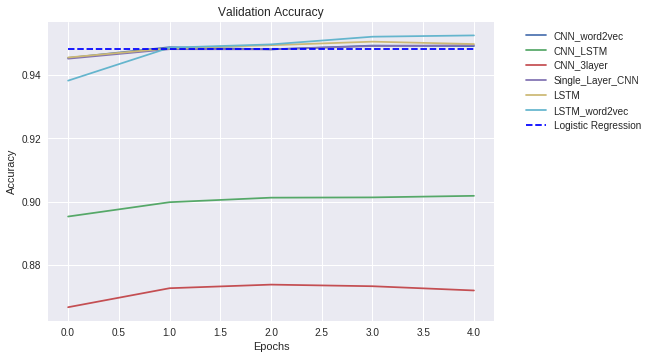

In [0]:
plt.plot(history_CNN_word2vec_val_acc, label='CNN_word2vec')
plt.plot(history_CNN_LSTM_val_acc, label='CNN_LSTM')
plt.plot(history_CNN_3layer_val_acc, label='CNN_3layer')
plt.plot(history_Single_CNN_val_acc, label = 'Single_Layer_CNN')
plt.plot(history_LSTM_val_acc, label='LSTM')
plt.plot(history_LSTM_word2vec.history['val_acc'], label='LSTM_word2vec')
plt.plot(clf_log_reg_val_acc, 'b--',label='Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1))

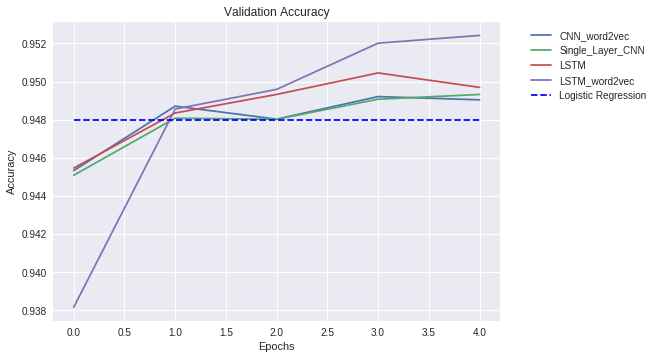

In [0]:
plt.plot(history_CNN_word2vec_val_acc, label='CNN_word2vec')
plt.plot(history_Single_CNN_val_acc, label = 'Single_Layer_CNN')
plt.plot(history_LSTM_val_acc, label='LSTM')
plt.plot(history_LSTM_word2vec.history['val_acc'], label='LSTM_word2vec')
plt.plot(clf_log_reg_val_acc, 'b--', label='Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1))

In [0]:
CNN_loss_CV = [[0.15867806600576956, 0.14844797611249977, 0.15340359469481055, 0.16712614287943414, 0.18203254485370618], [0.15457466403974898, 0.1469816956351596, 0.1564381671989064, 0.16329594736342903, 0.1733254220785029], [0.15400105525217386, 0.14825693263626433, 0.15385158227432066, 0.1661647267563019, 0.17958800006807987], [0.15405112911323945, 0.15073442152630664, 0.1536739381247447, 0.16592135551771553, 0.17623133139170644], [0.16017609305709607, 0.15040611022822137, 0.15602541653928315, 0.16926218657580067, 0.17924487900589767]]
CNN_acc_CV = [[0.9452894733727111, 0.9488879156259987, 0.9485209692120121, 0.9493969058131414, 0.9479764680815804], [0.9466619318181818, 0.9496330492424242, 0.9491358901515151, 0.9489701704545455, 0.9501302083333333], [0.9470999053030303, 0.9505089962121213, 0.9514441287878788, 0.9502604166666667, 0.9511008522727272], [0.947442559667518, 0.9510647616348709, 0.9511594597255206, 0.951561926622071, 0.9508753654705047], [0.9447311725777098, 0.949229385171013, 0.9499751414202581, 0.9488861004851127, 0.9488150760763909]]
CNN_scores_CV = [0.9479764680815804, 0.9501302083333333, 0.9511008522727272, 0.9508753654754436, 0.9488150761144913]

In [0]:
CNN_word2vec_loss_CV = [[0.17704728049277818, 0.1525951267527684, 0.15108784102531808, 0.1521006426402951, 0.15829219107979595], [0.17577238070362275, 0.1550740585697702, 0.1513036854181943, 0.1522090039083692, 0.15810197757214844], [0.17777795472259944, 0.15177121792486023, 0.14879456962393525, 0.14942425203031842, 0.15586661768148505], [0.1734880853765939, 0.15426567268706862, 0.1509998105082279, 0.1489602541112557, 0.15491613911195135], [0.17948960968265226, 0.1564334557379378, 0.1513976090452053, 0.1528747393243743, 0.1581259225512468]]
CNN_word2vec_acc_CV = [[0.9392289390513844, 0.9470768575182585, 0.9484972952498195, 0.9501307986411146, 0.949728341283839], [0.9403645833333333, 0.9477272727272728, 0.9504734848484848, 0.9504379734848485, 0.949609375], [0.9383522727272727, 0.948638731060606, 0.95, 0.9511482007575758, 0.95078125], [0.940766344316222, 0.9470164182934608, 0.9507569928684814, 0.9515027403267037, 0.9512778323444773], [0.9383034636349543, 0.9465896446031079, 0.9490636615520732, 0.9499514666610958, 0.9492293851724242]]
CNN_word2vec_scores_CV = [0.949728341283839, 0.949609375, 0.95078125, 0.9512778323607051, 0.9492293851653685]

In [0]:
log_reg_scores_CV = [0.9473017601590891, 0.9486979166666667, 0.948544034090909, 0.9493957078090413, 0.947761547385118]

In [0]:
LSTM_word2vec_loss_CV = [[0.17268906083778215, 0.14845246853999708, 0.1426729697419403, 0.14016610733564389, 0.14361078716407333], [0.175130438732837, 0.14814489760425534, 0.1433367947867902, 0.14108539918445537, 0.14218776903316294], [0.17214334399058398, 0.14888496969272666, 0.14277073786396421, 0.14027548016535796, 0.14284980073549156], [0.17620220253075525, 0.14570896262884306, 0.1395637472838431, 0.13824205180175952, 0.14210147053716982], [0.1769838466823698, 0.15226944419676083, 0.14412464555431861, 0.14095418196706958, 0.1459261563090021]]
LSTM_word2vec_acc_CV = [[0.9384832092423149, 0.9472899231779927, 0.9499769178868621, 0.9518589978811803, 0.9517287910891207], [0.9389914772727272, 0.9490411931818182, 0.9509943181818182, 0.9527225378787879, 0.9528053977272727], [0.9407907196969697, 0.948733428030303, 0.951266571969697, 0.9530658143939394, 0.9529947916666667], [0.938351542999009, 0.9498810355130379, 0.9526036056192182, 0.9536571218664077, 0.9534558884350659], [0.9387887970931422, 0.9470276285034596, 0.9507090603117944, 0.9523189469066662, 0.9514666540471608]]
LSTM_word2vec_scores_CV = [0.9517287910891207, 0.9528053977272727, 0.9529947916666667, 0.9534558884456492, 0.9514666540401051]

In [0]:
LSTM_loss_CV =[[0.16117385692275216, 0.15197119348849267, 0.14916572238181394, 0.1564679163555833, 0.16007379673761288], [0.15635200361615387, 0.14863930507527778, 0.1477008312265036, 0.14886366958572497, 0.15271029192323718], [0.15609896244855145, 0.14828444151454745, 0.1469578200986496, 0.14815039728577672, 0.15252177529813102], [0.15645131507684287, 0.14652716570869578, 0.1453860584281735, 0.14772775466647298, 0.15119483506998868], [0.15608781717869166, 0.14665044909591615, 0.14648430722915623, 0.151132461734081, 0.1558070011534307]]
LSTM_acc_CV =[[0.9444727216770635, 0.9483670884577597, 0.9490299593991548, 0.9488050567583244, 0.9487813827961317], [0.9462121212121212, 0.9484848484848485, 0.9493844696969697, 0.9506510416666667, 0.950875946969697], [0.946188446969697, 0.948922821969697, 0.9502604166666667, 0.9508641098484848, 0.9506155303030303], [0.9456551332177929, 0.9485670994939838, 0.9495614294345173, 0.9506741319996518, 0.9506267829599714], [0.9459385875259804, 0.9483179052590833, 0.9500580032741784, 0.9505433367323662, 0.9503302634638671]]
LSTM_scores_CV =[0.9487813827961317, 0.950875946969697, 0.9506155303030303, 0.9506267829769047, 0.9503302635019675]

In [0]:
from scipy.stats import ranksums
print('LSTM word2vec vs. LogReg:', ranksums(LSTM_word2vec_scores_CV, log_reg_scores_CV))
print('LSTM vs. LogReg:', ranksums(LSTM_scores_CV, log_reg_scores_CV))
print('CNN vs. LogReg:', ranksums(CNN_scores_CV, log_reg_scores_CV))
print('CNN word2vec vs. LogReg:', ranksums(CNN_word2vec_scores_CV, log_reg_scores_CV))

print('LSTM word2vec vs. CNN word2vec:', ranksums(LSTM_word2vec_scores_CV, CNN_word2vec_scores_CV))


LSTM word2vec vs. LogReg: RanksumsResult(statistic=2.6111648393354674, pvalue=0.009023438818080326)
LSTM vs. LogReg: RanksumsResult(statistic=2.40227165218863, pvalue=0.016293603621028527)
CNN vs. LogReg: RanksumsResult(statistic=1.775592090748118, pvalue=0.07580017458236125)
CNN word2vec vs. LogReg: RanksumsResult(statistic=2.40227165218863, pvalue=0.016293603621028527)
LSTM word2vec vs. CNN word2vec: RanksumsResult(statistic=2.6111648393354674, pvalue=0.009023438818080326)


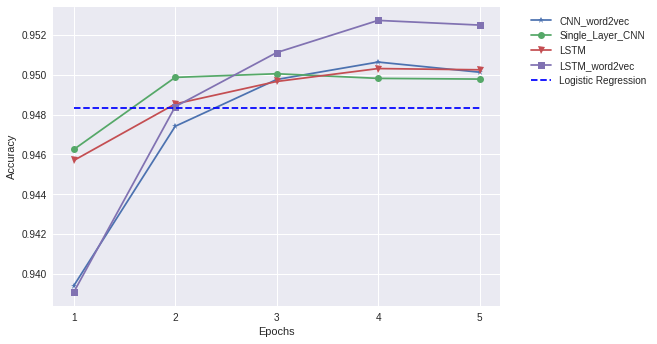

In [0]:
plt.plot(np.arange(1, 6),np.mean(CNN_word2vec_acc_CV, axis=0), '*-', label='CNN_word2vec')
plt.plot(np.arange(1, 6),np.mean(CNN_acc_CV, axis=0), 'o-',label = 'Single_Layer_CNN')
plt.plot(np.arange(1, 6), np.mean(LSTM_acc_CV, axis=0), 'v-',label='LSTM')
plt.plot(np.arange(1, 6),np.mean(LSTM_word2vec_acc_CV, axis=0), 's-', label='LSTM_word2vec')
plt.plot(np.arange(1, 6),[np.mean(log_reg_scores_CV)]*5, 'b--', label='Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks([1, 2, 3, 4, 5])
plt.savefig('Validation Accuracy 5-Fold CV')

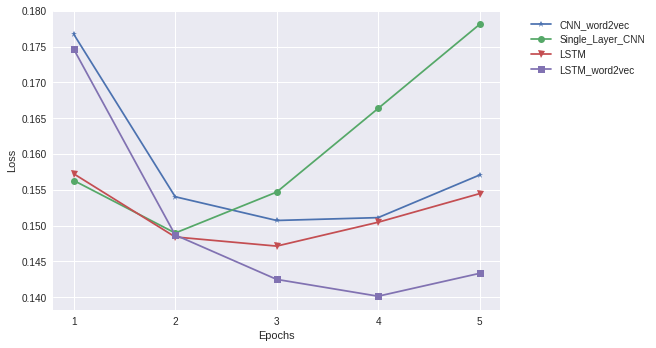

In [0]:
plt.plot(np.arange(1, 6),np.mean(CNN_word2vec_loss_CV, axis=0), '*-', label='CNN_word2vec')
plt.plot(np.arange(1, 6),np.mean(CNN_loss_CV, axis=0), 'o-', label = 'Single_Layer_CNN')
plt.plot(np.arange(1, 6),np.mean(LSTM_loss_CV, axis=0),'v-', label='LSTM')
plt.plot(np.arange(1, 6),np.mean(LSTM_word2vec_loss_CV, axis=0),'s-', label='LSTM_word2vec')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks([1, 2, 3, 4, 5])
plt.savefig('Validation Loss 5-Fold CV')